In [22]:
from os import listdir, path

import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, Precision, Recall, F1Score

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms

from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

#### Define train path

In [2]:
#convert to RGBA first because of error Projects/Fruit and veg/myenv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
#warnings.warn(

PATH =  "../RGBAKaggleData"
train_path = PATH + "/train"
test_path = PATH + "/test"
val_path = PATH + "/validation"
number_of_classes = len(listdir(train_path))
print(number_of_classes)

36


In [3]:
class_counts = {}

for class_name in listdir(train_path):  # Loop through class subdirectories
    class_path = path.join(train_path, class_name)
    if path.isdir(class_path):  # Ensure it's a directory
        num_images = len([f for f in listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        class_counts[class_name] = num_images

# Print the results
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

apple: 68 images
turnip: 97 images
chilli pepper: 87 images
raddish: 81 images
bell pepper: 89 images
pear: 89 images
sweetpotato: 69 images
pomegranate: 78 images
peas: 100 images
capsicum: 87 images
spinach: 97 images
lettuce: 97 images
kiwi: 88 images
lemon: 82 images
onion: 94 images
cauliflower: 79 images
potato: 76 images
jalepeno: 86 images
sweetcorn: 91 images
cucumber: 94 images
paprika: 83 images
watermelon: 84 images
mango: 86 images
cabbage: 91 images
grapes: 100 images
beetroot: 87 images
eggplant: 84 images
corn: 87 images
soy beans: 97 images
banana: 75 images
ginger: 68 images
garlic: 92 images
pineapple: 98 images
tomato: 92 images
orange: 69 images
carrot: 81 images


#### Load dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 32

train_dataset = datasets.ImageFolder(train_path, transform= transform)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = datasets.ImageFolder(test_path, transform= transform)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

val_dataset = datasets.ImageFolder(val_path, transform= transform)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


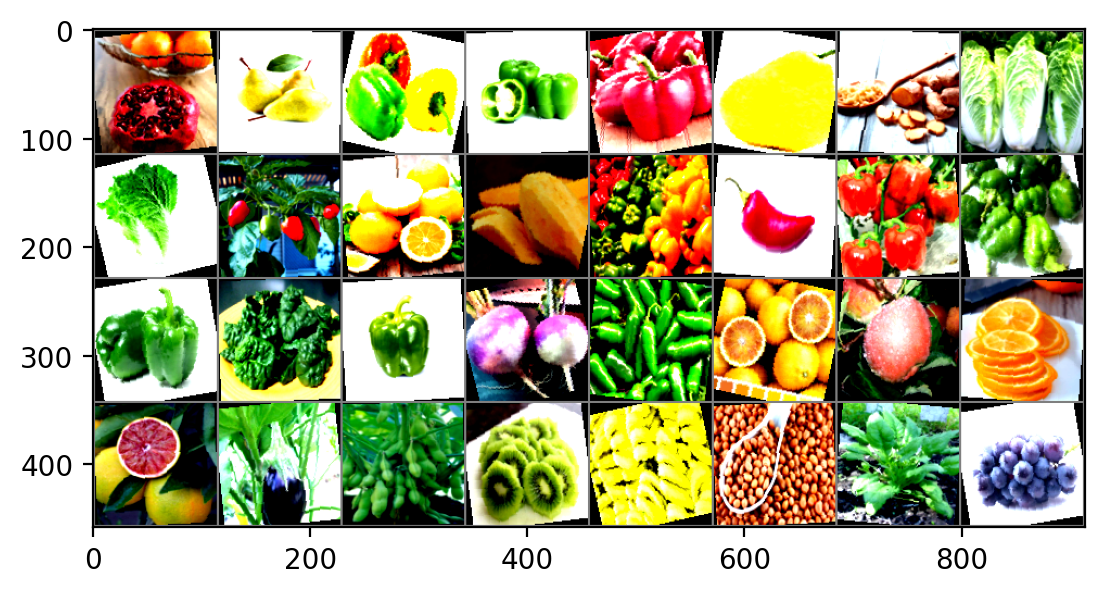

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#### Define Neural Network


In [6]:
print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU with MPS backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

PyTorch Version: 2.7.0.dev20250224
TorchVision Version: 0.22.0.dev20250224
Using GPU with MPS backend.


In [7]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5) 
        self.pool = nn.MaxPool2d(4, 4) 
        self.fc1 = nn.Linear(43264, 128)  
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net(num_classes=number_of_classes)
input_size = (3,112,112)
summary(net, input_size)
net = net.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 108, 108]           2,432
            Conv2d-2         [-1, 64, 104, 104]          51,264
         MaxPool2d-3           [-1, 64, 26, 26]               0
            Linear-4                  [-1, 128]       5,537,920
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 36]           4,644
Total params: 5,596,260
Trainable params: 5,596,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 8.46
Params size (MB): 21.35
Estimated Total Size (MB): 29.95
----------------------------------------------------------------


#### Define loss function and optimiser

In [8]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(net.parameters(), lr=0.005, weight_decay = 1e-4)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience = 4, factor =0.5)

#### Train the model

In [9]:
patience = 7
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []
total_iterations = len(train_dataloader)
for epoch in range(100):  
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total = total_iterations, ncols = 100, desc=f"Epoch {epoch+1}", leave =False):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}')

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            val_loss +=loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(net.state_dict(), 'my_best_model.pth')
    else:
        counter+=1   
        #print(f"Early stopping counter: Epoch {epoch +1} - {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered: {epoch +1}")
            break

print('Finished Training')

Early stopping triggered: 69
Finished Training


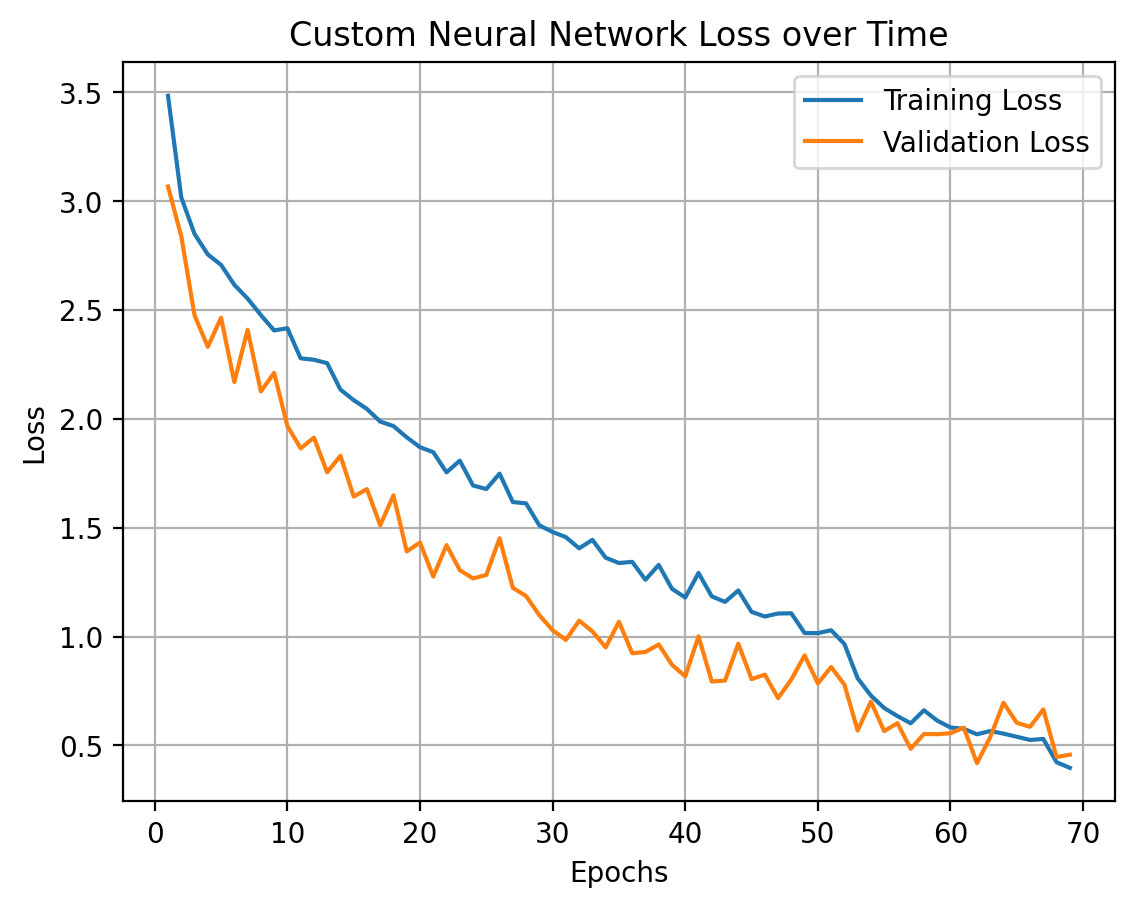

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1,len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.title('Custom Neural Network Loss over Time', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.savefig("../Results/LossEachEpoch.png", format='png', bbox_inches='tight')
plt.show()


## Test

In [11]:
# Initialize metrics
accuracy = MulticlassAccuracy(num_classes=number_of_classes).to(device)  
precision = Precision(num_classes= number_of_classes, task="multiclass").to(device)
recall = Recall(num_classes=number_of_classes, task="multiclass").to(device)
f1_score = F1Score(num_classes=number_of_classes, task="multiclass").to(device)

In [12]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

Accuracy: 89.10%
Precision: 0.8913649320602417
Recall: 0.8913649320602417
F1-Score: 0.8913649320602417


In [13]:
all_preds = []
all_labels = []
classes = test_dataloader.dataset.classes

with torch.no_grad():
    for data in test_dataloader:
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print a detailed classification report
print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       0.88      0.70      0.78        10
       banana       0.78      0.78      0.78         9
     beetroot       0.83      1.00      0.91        10
  bell pepper       0.73      0.80      0.76        10
      cabbage       0.83      1.00      0.91        10
     capsicum       0.67      0.80      0.73        10
       carrot       1.00      0.90      0.95        10
  cauliflower       0.90      0.90      0.90        10
chilli pepper       1.00      0.70      0.82        10
         corn       1.00      1.00      1.00        10
     cucumber       0.90      0.90      0.90        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.80      0.89        10
       grapes       0.91      1.00      0.95        10
     jalepeno       0.88      0.70      0.78        10
         kiwi       1.00      0.80      0.89        10
        l

## Validation

In [14]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

Accuracy: 90.51%
Precision: 0.905633807182312
Recall: 0.905633807182312
F1-Score: 0.905633807182312


In [15]:
all_preds = []
all_labels = []
classes = val_dataloader.dataset.classes

with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       0.86      0.60      0.71        10
       banana       0.88      0.78      0.82         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.78      0.78      0.78         9
      cabbage       0.90      0.90      0.90        10
     capsicum       0.91      1.00      0.95        10
       carrot       1.00      0.78      0.88         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.86      0.67      0.75         9
         corn       0.80      0.80      0.80        10
     cucumber       1.00      0.60      0.75        10
     eggplant       0.91      1.00      0.95        10
       garlic       0.80      0.80      0.80        10
       ginger       0.89      0.80      0.84        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.75      1.00      0.86         9
         kiwi       0.82      0.90      0.86        10
        l

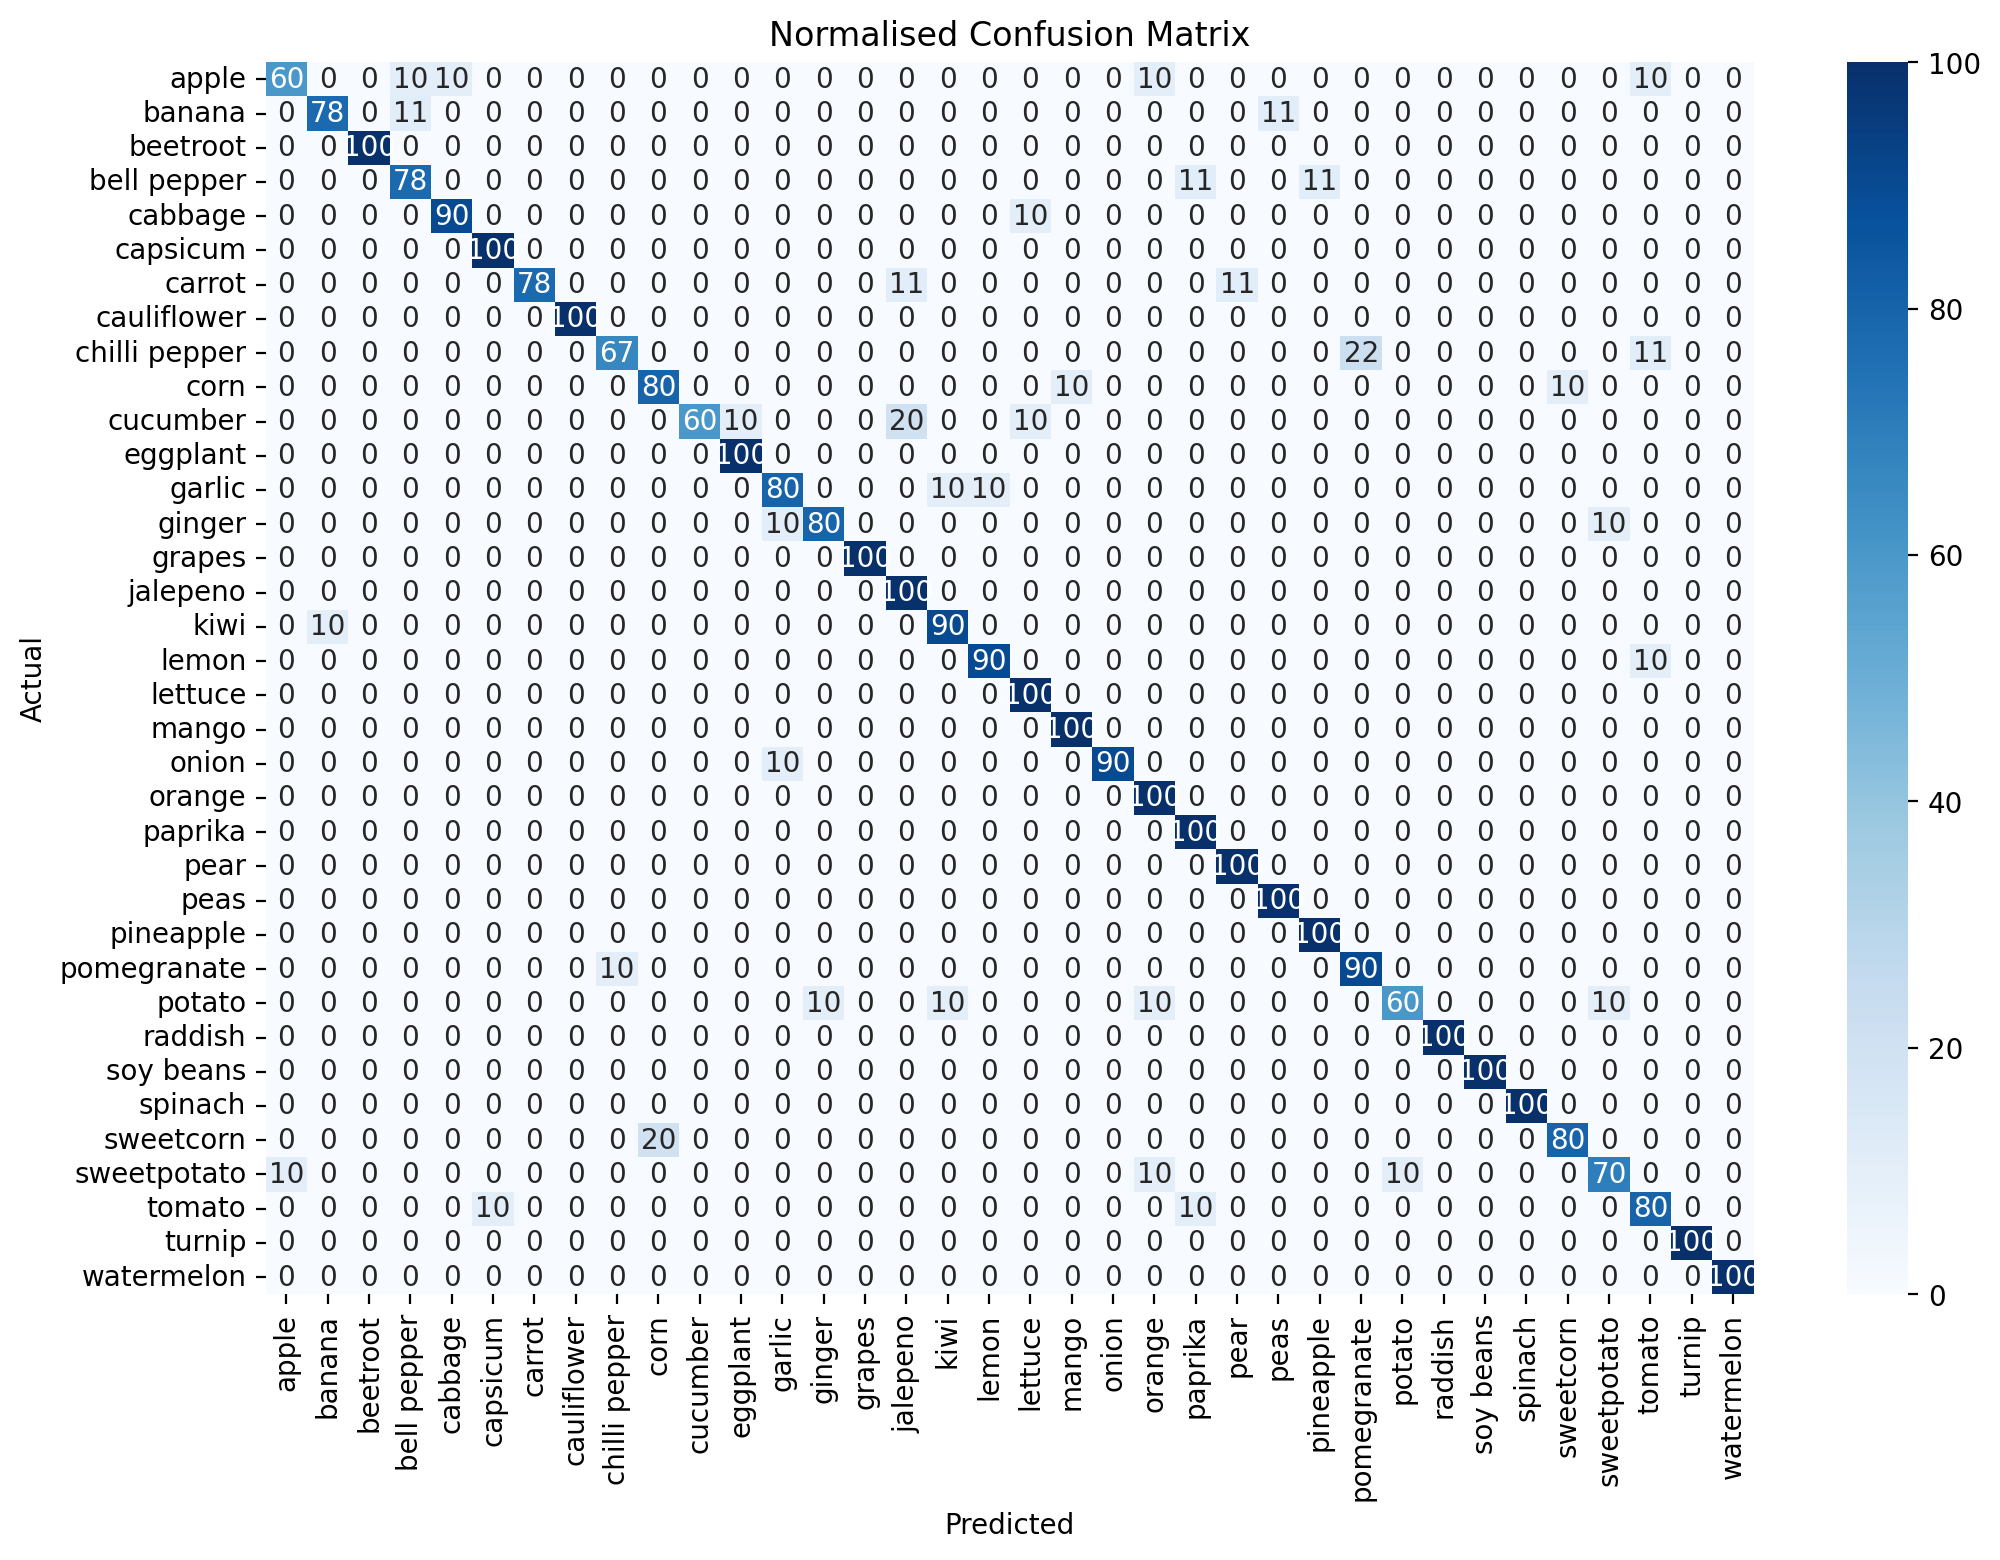

In [ ]:
cm = metrics.confusion_matrix(all_labels,all_preds)
cm_normalised = cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]*100
class_names = [class_name for class_name in classes]
plt.figure(figsize=(12,8))
sns.heatmap(cm_normalised, annot=True, fmt = '.0f', cmap= 'Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=16, fontweight='bold')
plt.title('Normalised Confusion Matrix', fontsize=16, fontweight='bold')
plt.savefig("../Results/ConfusionMatrix.png", format='png', bbox_inches='tight')
plt.show()

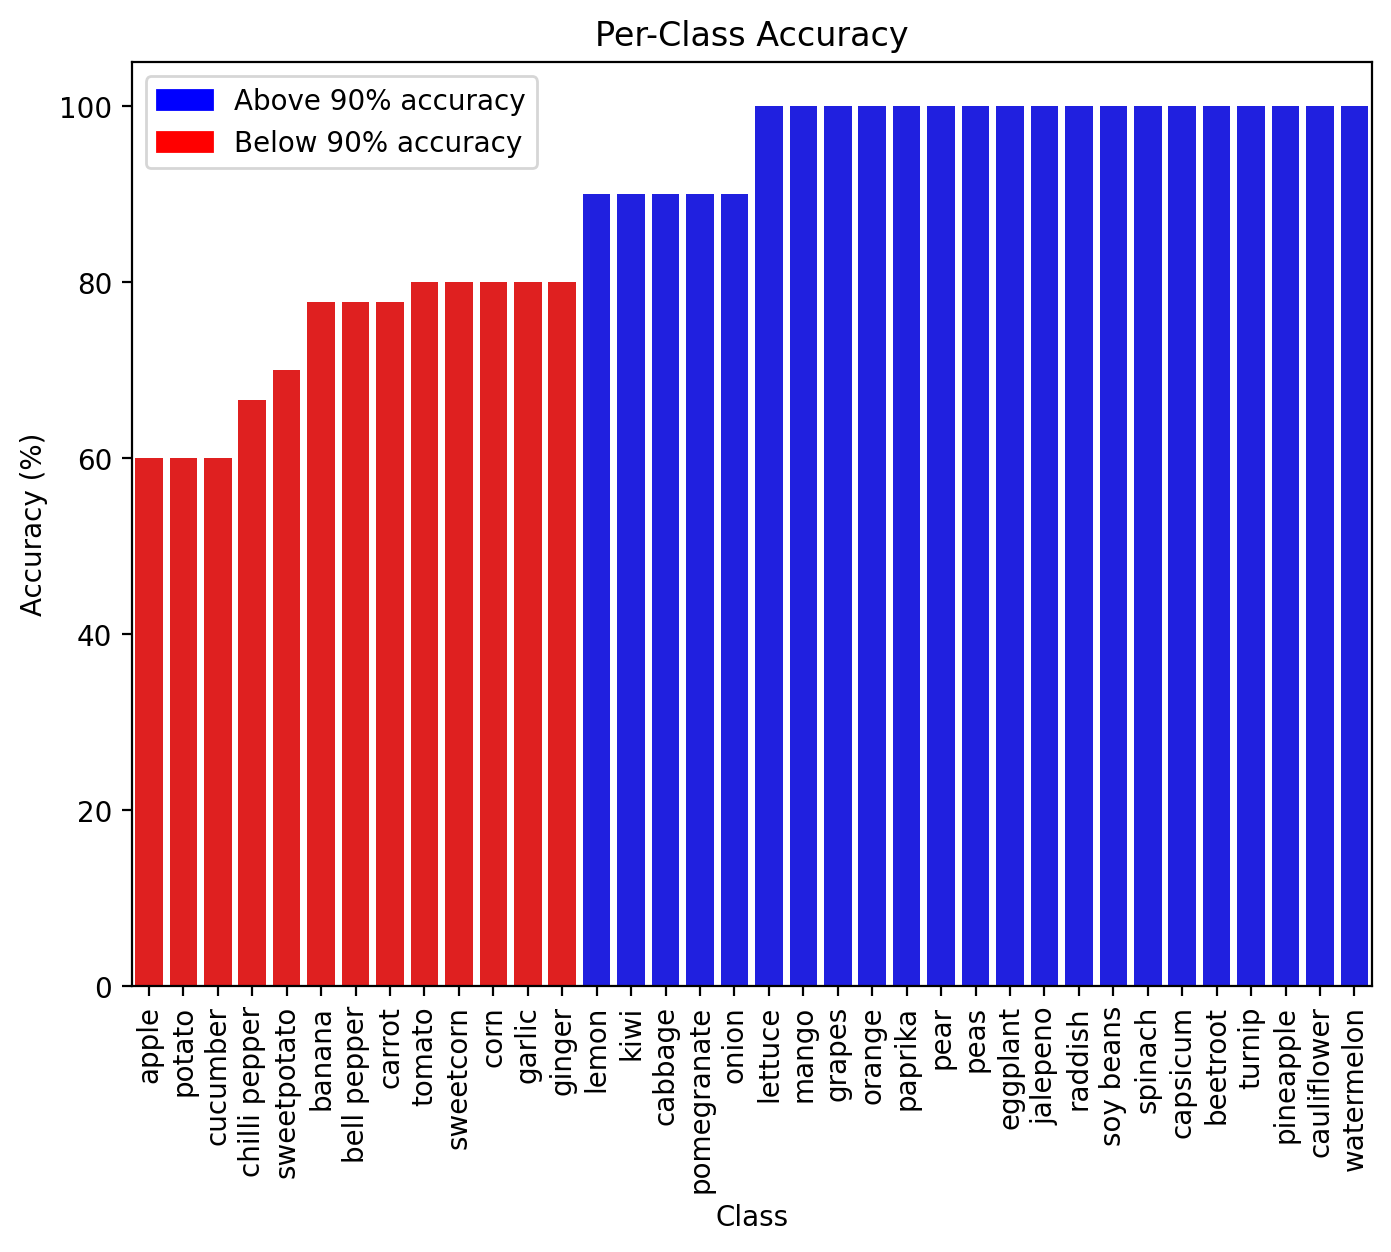

In [ ]:
threshold = 90
class_accuracy = cm_normalised.diagonal()
accuracy_data_df = pd.DataFrame({'Accuracy':class_accuracy, 'Classes':class_names}).sort_values(by = 'Accuracy', ascending=True)
accuracy_data_df = accuracy_data_df.sort_values(by = 'Accuracy')
plt.figure(figsize=(8,6))
colours = {cls:'red' if acc < threshold else 'blue' for cls, acc in zip(accuracy_data_df['Classes'],accuracy_data_df['Accuracy'])}
sns.barplot(accuracy_data_df, y ='Accuracy', x = 'Classes', palette=colours, hue= 'Classes')
plt.ylabel('Accuracy (%)', fontsize=16, fontweight='bold')
plt.title('Accuracy for Each Class on the Validation Set', fontsize=16, fontweight='bold', pad=20, loc='center')
plt.xticks(rotation = 45)
plt.xlabel('Class', fontsize=16, fontweight='bold')
above_threshold_patch = mpatches.Patch(color = 'blue', label=f"Above {threshold}% accuracy")
below_threshold_patch = mpatches.Patch(color = 'red', label=f"Below {threshold}% accuracy")
plt.legend(handles = [above_threshold_patch, below_threshold_patch])
plt.savefig("../Results/PerClassAccuracy.png", format='png', bbox_inches='tight')

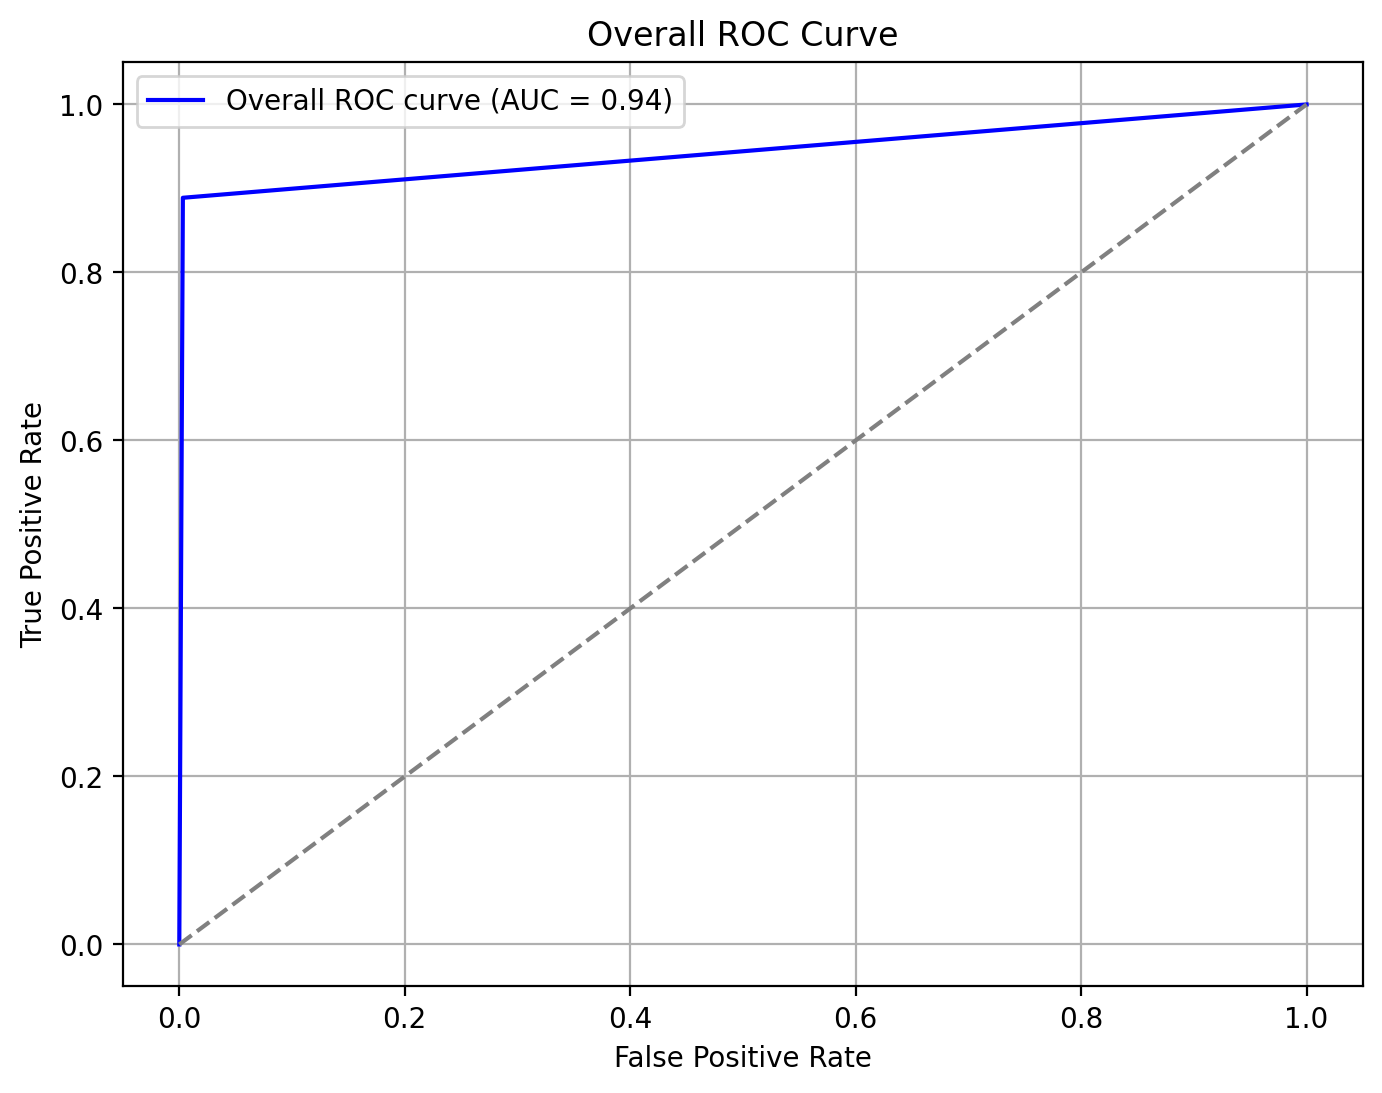

In [ ]:
y_true_bin = label_binarize(all_labels, classes=range(len(classes)))
y_pred_bin = label_binarize(all_preds, classes=range(len(classes)))


fpr, tpr, _ = metrics.roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = metrics.auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Overall ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate", fontsize=16, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=16, fontweight='bold')
plt.title("Overall ROC Curve", fontsize=16, fontweight='bold')
plt.legend()
plt.grid()
plt.savefig("../Results/RocCurve.png", format='png', bbox_inches='tight')
plt.show()

# Save Model

In [19]:
model_file_name = "my_best_model.pth"
#torch.save(net.state_dict(),model_file_name)

source = model_file_name
destination = "../" + model_file_name

#copy model to the directory that can be used by the main.py file
with open(source, "rb") as src, open(destination, "wb") as dest:
    while chunk := src.read(4096):  
        dest.write(chunk)
